In [16]:
%matplotlib inline

import os
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Had unicode problems without this
matplotlib.rc('font', family='Arial')

# pandasql is not necessary for the core analysis
try:
    import pandasql
    sqldf = lambda q: pandasql.sqldf(q, globals())
except ImportError, e:
    if e.message != 'No module named optional':
        raise
        
# Import a series of files from WOI. Here I just use their download functionality to get CSV files
def import_WOI_datasets(files):
    results = None
    
    for file in files:
        data = pd.read_csv(file)
        data['source'] = pd.Series([file] * len(data.index), index=data.index)
        if results is None:
            results = data
        else:
            results = pd.concat([results, data])
            
    return results

# Wrapper for how I'm producing scatter plots
def scatter_wrap(df, axis, x, y, x_base=None, y_base=None, color='b'):
    df.plot(kind='scatter', x=x, y=y, ax=axis, color=color)
    
    if x_base is not None:
        axis.set_xlim(x_base, 100)

    if y_base is not None:
        axis.set_ylim(y_base, 100)

    rho = round(df[x].corr(df[y]), 2)
    
    # Show line of best fit
    best_fit = np.poly1d(np.polyfit(df[x], df[y], 1))
    axis.plot(df[x], best_fit(df[x]), c=color, label=u'{0} vs {1} (\u03c1 = {2})'.format(x, y, rho))
    
    # Legend in lower right corner
    axis.legend(loc=4)
    
    # Show line of best fit and Pearson correlation coefficient
    print best_fit
    print df[x].corr(df[y])

We are looking at 82 goalies
 
0.06652 x + 81.08


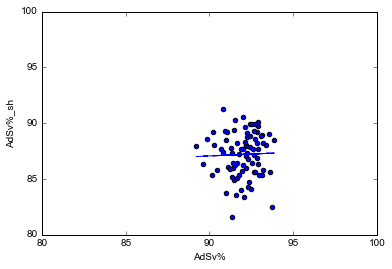

 
-0.2237 x + 115.2
-0.07119866636
 
0.0846 x + 79.41
0.0293027749949
 
0.5793 x + 30.1
0.310775379311


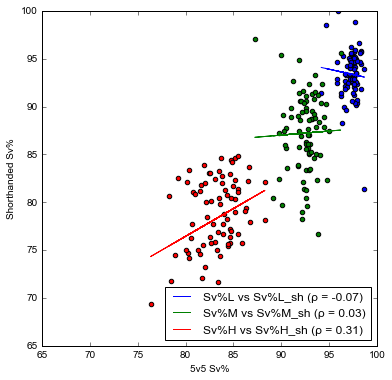

 
0.1835 x + 80.35
0.341914898222
 
0.1667 x + 78.61
0.263603334195
 
0.008387 x + 96.62
0.024714832327


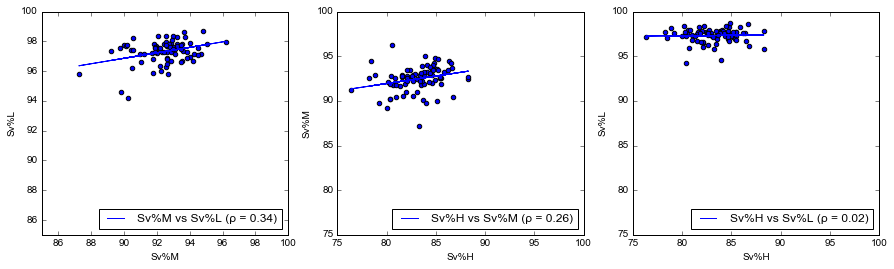

In [17]:
# In this block I take pre-aggregated data by goaltender across the 2013-2014 to 2015-2016 seasons
# and demonstrate some basic relationships

results_5v5 = import_WOI_datasets(['Goalies_5v5.csv'])
results_sh = import_WOI_datasets(['Goalies_SH.csv'])

stats = pd.merge(results_5v5, 
                 results_sh[['Name', 'Team', 'Gm', 'AdSv%', 'Sv%L', 'Sv%M', 'Sv%H']], 
                 on=['Name', 'Team'], 
                 how='inner', 
                 suffixes=('','_sh'))
    
print "We are looking at {0} goalies".format(len(stats))

# Replicate absence of correlation between 5 on 5 ("5v5") and shorthanded ("SH") adjusted save percentage
stats.plot(kind='scatter', x='AdSv%', y='AdSv%_sh')
plt.xlim(80, 100)
plt.ylim(80, 100)
plt.plot(stats['AdSv%'], np.poly1d(np.polyfit(stats['AdSv%'], stats['AdSv%_sh'], 1))(stats['AdSv%']))
print np.poly1d(np.polyfit(stats['AdSv%'], stats['AdSv%_sh'], 1))

plt.show()

# Show correlations between 5 on 5 and shorthanded save percentages per goalie
fig, axs = plt.subplots(ncols=1, figsize=(6, 6))
  
scatter_wrap(stats, axs, 'Sv%L', 'Sv%L_sh', 85, 85, color='b')
scatter_wrap(stats, axs, 'Sv%M', 'Sv%M_sh', 75, 75, color='g')
scatter_wrap(stats, axs, 'Sv%H', 'Sv%H_sh', 65, 65, color='r')

plt.xlabel('5v5 Sv%')
plt.ylabel('Shorthanded Sv%')
plt.show()

# Show correlation between save percentages from different shot difficulties, per goalie
fig, axs = plt.subplots(ncols=3, figsize=(15, 4))

scatter_wrap(stats, axs[0], 'Sv%M', 'Sv%L', 85, 85)
scatter_wrap(stats, axs[1], 'Sv%H', 'Sv%M', 75, 75)
scatter_wrap(stats, axs[2], 'Sv%H', 'Sv%L', 75, 75)

plt.show()

Looking at 30 starters representing 86 starter seasons and 114 reserve seasons
 
0.2727 x + 70.72
0.222635486491
 
0.2711 x + 67.16
0.218446815122
 
0.4327 x + 47.08
0.37078724248


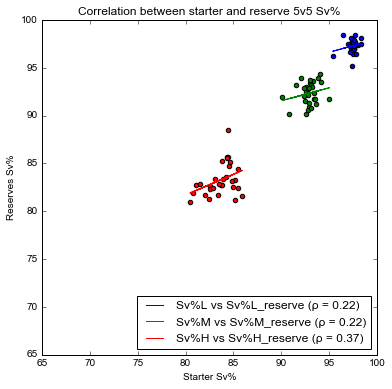

Looking at 30 starters representing 87 starter seasons and 104 reserve seasons
 
0.3874 x + 56.79
0.319617053188
 
0.2831 x + 62.4
0.234055375898
 
0.1888 x + 63.6
0.228628840602


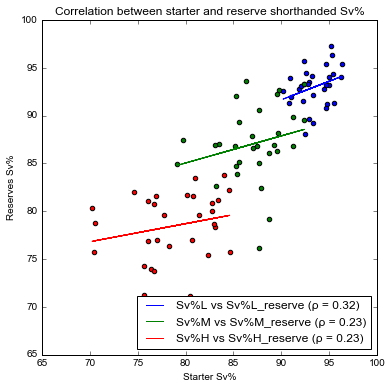

In [18]:
# In this block I want to compare starters with their own reserves, separately for 5v5 
# and shorthanded. The hypothesis is that the correlation between starters and their 
# backups is much stronger in shorthanded situations than in 5v5 play

# Compare starter numbers versus their own reserves
def starters_vs_reserves(by_season, title, x_base=65, y_base=65):
    
    # Exclude seasons where goalies have played for multiple teams.
    # These could most easily be included if War-on-ice let me split individual stats by season and team
    stripped_by_season = by_season[by_season['Team'].str.len() == 3]

    # They'll always be Phoenix to me
    stripped_by_season.loc[stripped_by_season['Team'] == 'ARI', 'Team'] = 'PHX'
    
    # Sum up by minutes played and treat the goalie with the highest (by team) over the 3 season
    # season span as the starter
    goalie_total = stripped_by_season[['Team', 'Name', 'TOI']].groupby(['Team', 'Name'], as_index=False).agg(np.sum)
    starter_idx = goalie_total.groupby(['Team'])['TOI'].transform(max) == goalie_total['TOI']

    # Split the original per-season dataset by the starter classification
    starters = stripped_by_season[stripped_by_season['Name'].isin(goalie_total[starter_idx]['Name'])]
    reserves = stripped_by_season[stripped_by_season['Name'].isin(goalie_total[~starter_idx]['Name'])]
        
    # The easier way continues to throw a warning
    starters.insert(len(starters.columns), 'type', pd.Series(['starter'] * len(starters.index),  index=starters.index))
    reserves.insert(len(reserves.columns), 'type', pd.Series(['reserve'] * len(reserves.index),  index=reserves.index))

    tog = pd.concat([starters, reserves])

    tog['Sh.L'] = tog['S.L'] + tog['G.L']
    tog['Sh.M'] = tog['S.M'] + tog['G.M']
    tog['Sh.H'] = tog['S.H'] + tog['G.H']

    # Calculate save percentage numbers aggregated over all the reserves. Each team has one starter, 
    # regardless of whether he was the starter in all three seasons
    grouped = tog.groupby(['Team', 'type'], as_index=False).agg(np.sum)
    grouped['Sv%L'] = 100 * (1 - (grouped['G.L'] / grouped['Sh.L']))
    grouped['Sv%M'] = 100 * (1 - (grouped['G.M'] / grouped['Sh.M']))
    grouped['Sv%H'] = 100 * (1 - (grouped['G.H'] / grouped['Sh.H']))

    stats_svr = pd.merge(grouped[grouped['type'] == 'starter'],
                     grouped[grouped['type'] == 'reserve'][['Team', 'Sh.L', 'Sh.M', 'Sh.H', 'Sv%L', 'Sv%M', 'Sv%H']], 
                     on=['Team'], 
                     how='inner', 
                     suffixes=('','_reserve'))

    # I am very amused at how no Chad Johnson leads Buffalo with 45 starts
    print "Looking at {0} starters representing {1} starter seasons and {2} reserve seasons".format(
        len(stats_svr), 
        len(starters), 
        len(reserves))

    fig, axs = plt.subplots(ncols=1, figsize=(6, 6))

    scatter_wrap(stats_svr, axs, 'Sv%L', 'Sv%L_reserve', x_base, y_base, color='b')
    scatter_wrap(stats_svr, axs, 'Sv%M', 'Sv%M_reserve', x_base, y_base, color='g')
    scatter_wrap(stats_svr, axs, 'Sv%H', 'Sv%H_reserve', x_base, y_base, color='r')

    plt.xlabel('Starter Sv%')
    plt.ylabel('Reserves Sv%')
    plt.title(title)

    plt.show()

results_5v5_by_season = import_WOI_datasets(['Goalies_5v5_by_season.csv'])
results_SH_by_season = import_WOI_datasets(['Goalies_SH_by_season.csv'])

starters_vs_reserves(results_5v5_by_season, 'Correlation between starter and reserve 5v5 Sv%')
starters_vs_reserves(results_SH_by_season, 'Correlation between starter and reserve shorthanded Sv%')